## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Clone and install keras-uncertainty

In [2]:
# keras_uncertainty imports 
# clone and install this library 

!git clone https://github.com/mvaldenegro/keras-uncertainty.git
!pip install --user git+https://github.com/mvaldenegro/keras-uncertainty.git

fatal: destination path 'keras-uncertainty' already exists and is not an empty directory.
  Cloning https://github.com/mvaldenegro/keras-uncertainty.git to /tmp/pip-req-build-3x56pjbv
  Running command git clone -q https://github.com/mvaldenegro/keras-uncertainty.git /tmp/pip-req-build-3x56pjbv


In [3]:
# set the directory path 
%cd keras-uncertainty

/content/keras-uncertainty


## Imports

In [4]:
# regular imports
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input

import keras_uncertainty
#from keras_uncertainty.models import DeepEnsembleRegressor, StochasticRegressor, TwoHeadStochasticRegressor, MCDropoutRegressor
#(this import is deliberately commented, as it allows to modify the behaviour of keras-uncertainty code as per my thesis requirement)
from keras_uncertainty.layers import DropConnectDense, VariationalDense, FlipoutDense, StochasticDropout
from keras_uncertainty.metrics import gaussian_interval_score
from keras_uncertainty.losses import regression_gaussian_nll_loss, regression_gaussian_beta_nll_loss

from keras_uncertainty.models.DeepEnsembleClassifier import DeepEnsemble
from keras_uncertainty.models.stochastic_model import StochasticModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# if eager execution is not disabled following error occurs:
# TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), 
#dtype=tf.float32, name=None), name='Placeholder:0', description="created 
#by layer 'tf.cast_4'"), an intermediate Keras symbolic input/output, 
#to a TF API that does not allow registering custom dispatchers, 
#such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. 
#Keras Functional model construction only supports TF API calls that 
#*do* support dispatching, such as `tf.math.add` or `tf.reshape`. 
#Other APIs cannot be called directly on symbolic Kerasinputs/outputs. 
#You can work around this limitation by putting the operation in a custom 
#Keras layer `call` and calling that layer on this symbolic input/output.

Keras Uncertainty will use standalone Keras backend

## Create results folder

In [5]:
path = '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/training/'

if not os.path.exists(path+'/results'):
    os.makedirs(path+'/results')

## DeepEnsembleRegressor

In [6]:
class DeepEnsembleRegressor(DeepEnsemble):
    """
        Implementation of a Deep Ensemble for regression.
        Uses two models, one for training and another for inference/testing. The user has to provide a model function that returns
        the train and test models, and use the provided deep_ensemble_nll_loss for training.
    """
    def __init__(self, model_fn=None, num_estimators=None, models=None):
        """
            Builds a Deep Ensemble given a function to make model instances, and the number of estimators.
            For training it uses a model that only outputs the mean, while the loss uses both the mean and variance produced by the model.
            For testing, a model that shares weights with the training model is used, but the testing model outputs both mean and variance. The final
            prediction is made with a mixture of gaussians, where each gaussian is one trained model instance.
        """
        super().__init__(model_fn=model_fn, num_estimators=num_estimators, models=models,
                         needs_test_estimators=True)

    def fit(self, X, y, epochs=10, batch_size=32, **kwargs):
        """
            Fits the Deep Ensemble, each estimator is fit independently on the same data.
        """

        for i in range(self.num_estimators):
            history = self.train_estimators[i].fit(X, y, epochs=epochs, batch_size=batch_size, **kwargs)


            if not os.path.exists(path+'/results/ensemble'):
                os.makedirs(path+'/results/ensemble')

            # plotting history for individual ensemble component 
            plt.plot(range(epochs), history.history['loss'], label='training loss')
            plt.plot(range(epochs), history.history['val_loss'], label='val loss')
            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.title('Ensemble component '+str(i)+' loss plot')
            plt.legend()
            plt.savefig(path+'results/ensemble/loss_plot_'+str(i)+'.pdf')
            plt.show()

            plt.plot(range(epochs), history.history['mae'], label='training mae')
            plt.plot(range(epochs), history.history['val_mae'], label='val mae')
            plt.legend()
            plt.xlabel('epochs')
            plt.ylabel('mae')
            plt.title('Ensemble component '+str(i)+' mae plot') 
            plt.savefig(path+'results/ensemble/mae_plot_'+str(i)+'.pdf')
            plt.show()
            
            # saving the individual ensemble component 
            self.train_estimators[i].save(path+'results/ensemble/model_'+str(i)+'.h5')
    
    def fit_generator(self, generator, epochs=10, **kwargs):
        """
            Fits the Deep Ensemble, each estimator is fit independently on the same data.
        """

        for i in range(self.num_estimators):
            self.train_estimators[i].fit_generator(generator, epochs=epochs, **kwargs)
            

    def predict(self, X, batch_size=32, output_scaler=None, num_ensembles=None, disentangle_uncertainty=False, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are used to build a gaussian mixture and its mean and standard deviation returned.
        """
        
        means = []
        variances = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for estimator in estimators:
            mean, var  = estimator.predict(X, batch_size=batch_size, **kwargs)

            if output_scaler is not None:
                mean = output_scaler.inverse_transform(mean)

                # This should work but not sure if its 100% correct
                # Its not clear how to do inverse scaling of the variance
                sqrt_var = np.sqrt(var)
                var = output_scaler.inverse_transform(sqrt_var)
                var = np.square(var)

            means.append(mean)
            variances.append(var)

        means = np.array(means)
        variances = np.array(variances)
        
        mixture_mean = np.mean(means, axis=0)
        mixture_var  = np.mean(variances + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
                
        if disentangle_uncertainty:
            epi_var = np.var(means, axis=0)
            ale_var = np.mean(variances, axis=0)

            return mixture_mean, np.sqrt(ale_var), np.sqrt(epi_var)

        return mixture_mean, np.sqrt(mixture_var)

    def predict_generator(self, generator, steps=None, num_ensembles=None, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are used to build a gaussian mixture and its mean and standard deviation returned.
        """
        
        means = []
        variances = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        for estimator in estimators:
            mean, var  = estimator.predict_generator(generator, steps=steps, **kwargs)
            means.append(mean)
            variances.append(var)

        means = np.array(means)
        variances = np.array(variances)
        
        mixture_mean = np.mean(means, axis=0)
        mixture_var  = np.mean(variances + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
                
        return mixture_mean, np.sqrt(mixture_var)

## StochasticModel

In [7]:
class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)

## StochasticRegressor

In [8]:
class  StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=10):
        super().__init__(model, num_samples)

    def predict(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)

        return mean_pred, std_pred    


## Load and process California Housing data

In [9]:
np.set_printoptions(suppress=True)

# load the california housing data from csv
train_file = '/content/sample_data/california_housing_train.csv'
test_file = '/content/sample_data/california_housing_test.csv'

train_combined = pd.read_csv(train_file)
test = pd.read_csv(test_file)

# split the data in validation and test (from test.csv)
train, val = train_test_split(train_combined, test_size=0.25)

# assign the target variable
target = 'median_house_value'

# extract the target label in all sets
train_labels_df= train[target]
val_labels_df = val[target]
test_labels_df = test[target]

# extract the data from all sets 
train_data_df = train.drop(columns=target, axis=1)
val_data_df = val.drop(columns=target, axis=1)
test_data_df = test.drop(columns=target, axis=1)

train_data_unnormalized = train_data_df.to_numpy()
train_labels_unnormalized = train_labels_df.to_numpy()

val_data_unnormalized = val_data_df.to_numpy()
val_labels_unnormalized = val_labels_df.to_numpy()

test_data_unnormalized = test_data_df.to_numpy()
test_labels_unnormalized = test_labels_df.to_numpy()

# normalize the data using minmax 
minmax = MinMaxScaler() 

train_data = minmax.fit_transform(train_data_unnormalized)
train_label_temp = np.expand_dims(train_labels_unnormalized, axis=1)
train_labels = minmax.fit_transform(train_label_temp)

val_data = minmax.fit_transform(val_data_unnormalized)
val_label_temp = np.expand_dims(val_labels_unnormalized, axis=1)
val_labels = minmax.fit_transform(val_label_temp)

test_data = minmax.fit_transform(test_data_unnormalized)
test_label_temp = np.expand_dims(test_labels_unnormalized, axis=1)
test_labels = minmax.fit_transform(test_label_temp)

print('Training data shape \n', train_data.shape)
print('Training labels shape \n', train_labels.shape)
print('Training data \n ', train_data)
print('Training labels \n ', train_labels)

print('Validation data shape \n ',val_data.shape)
print('Validation labels shape \n ', val_labels.shape)
print('Validation data \n ', val_data)
print('Validation labels \n ', val_labels)

print('Test data shape \n ', test_data.shape)
print('Test labels shape \n ', test_labels.shape)
print('Test data \n ', test_data)
print('Test labels \n ', test_labels)

Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Training data 
  [[0.62962963 0.15957447 0.70588235 ... 0.02270243 0.028125   0.22845202]
 [0.71371371 0.02340426 0.09803922 ... 0.04327476 0.13388158 0.27918236]
 [0.61861862 0.1393617  0.64705882 ... 0.02715883 0.06480263 0.3001131 ]
 ...
 [0.5995996  0.16382979 0.64705882 ... 0.07351663 0.12713816 0.09113667]
 [0.18618619 0.55425532 1.         ... 0.02387959 0.07828947 0.31538875]
 [0.61561562 0.14574468 0.68627451 ... 0.03444603 0.06315789 0.26724459]]
Training labels 
  [[0.25360926]
 [0.30886677]
 [0.40948491]
 ...
 [0.40433029]
 [0.8049472 ]
 [0.3488666 ]]
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Validation data 
  [[0.72569089 0.21351931 0.16       ... 0.07906659 0.08924441 0.1773148 ]
 [0.36949846 0.5139485  0.56       ... 0.08688637 0.08230532 0.11368809]
 [0.50767656 0.43025751 0.56       ... 0.05138708 0.06245181 0.1991007 ]
 ...
 [0.63357216 0.13197425 0.72       ... 0.079128

## Plot function to visualize the ground truth and prediction

In [10]:
# function to visualize the ground truth with the predicted value and (corridor of uncertainty)

def plot(ground_truth, prediction_mean, prediction_std, path):
    plt.figure(figsize=(30, 4))
    plt.plot(range(ground_truth.shape[0]),  ground_truth, color='k', label='ground truth', marker='o')
    plt.plot(range(ground_truth.shape[0]), prediction_mean, color='r', label='prediction', marker='o')
   
    y_pred_mean = prediction_mean.reshape((-1,))
    y_pred_std = prediction_std.reshape((-1,))
    y_pred_up_1 = y_pred_mean + y_pred_std
    y_pred_down_1 = y_pred_mean - y_pred_std

    plt.fill_between(range(ground_truth.shape[0]), y_pred_down_1, y_pred_up_1, color=(0, 0, 0.9, 0.7), label='corridor of uncertainty ($\pm$ One $\sigma$) ', alpha=0.5)
    #plt.plot(range(ground_truth.shape[0]), y_pred_mean, '.', color=(0, 0.9, 0.0, 0.8), markersize=0.2, label='Mean')

    #plt.set_title('{}\nInterval Score: {:.2f}'.format(key, score))
    #plt.set_ylim([-20.0, 20.0])

    #plt.axvline(x=-4.0, color='black', linestyle='dashed')
    #plt.axvline(x= 4.0, color='black', linestyle='dashed')
    #plt.get_xaxis().set_ticks([])
    #plt.get_yaxis().set_ticks([])    

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend()
    plt.grid()
    plt.xlabel('Input sample #')
    plt.ylabel('Target Variable (normalized)')
    plt.title('Ground Truth and Model Prediction')
    plt.savefig(path)
    plt.show()

## Hyperparameters for Uncertainty methods 

In [11]:
epochs = 2
num_samples = 20  # number of sample to be taken for dropout, dropout and flipout (min should be 10 and normal range is (50, 100))
num_estimators = 2  # ensemble components

#flags
ensemble = False
dropout = False
dropconnect = True
flipout = False

# ENSEMBLE MODEL PREDICTION AND PLOTTING
start_index = np.random.randint(test_data.shape[0]-150)
random = range(start_index, start_index+100)

## Ensemble : Model (MLP)

In [12]:
# ENSEMBLE MODEL
def train_ensemble_model(x_train, y_train, x_val, y_val, x_test, epochs, num_estimators):
    def model():
        # this model definition has been obtained from the hyperparameter optimization 
        # not the last layer though
        inp = Input(shape=(8,))
        x = Dense(4, activation='tanh')(inp)
        x = Dense(4, activation='tanh')(x)
        x = Dense(4, activation='tanh')(x)
        x = Dense(4, activation='tanh')(x)
        x = Dense(4, activation='tanh')(x)
        mean = Dense(1, activation='softplus')(x)
        var = Dense(1, activation='softplus')(x)

        train_model = Model(inp, mean)
        pred_model = Model(inp, [mean, var])

        train_model.compile(loss=regression_gaussian_nll_loss(var), optimizer='sgd', metrics=['mae'])
        
        return train_model, pred_model

    model = DeepEnsembleRegressor(model, num_estimators=num_estimators) 
    model.fit(x_train, y_train, validation_data=(x_val, y_val), verbose=2, epochs=epochs)
    pred_mean, pred_std = model.predict(x_test)
       
    return pred_mean, pred_std

## Ensemble : Training (MLP) 

In [13]:
# TRAINING ENSEMBLE MODEL 
if ensemble:
    mean_ensemble, std_ensemble = train_ensemble_model(train_data , train_labels, val_data, val_labels, test_data, epochs=epochs, num_estimators=num_estimators)

## Ensemble : Ground Truth vs Prediction visualization (Along with $\pm$ $sigma$ corridor of uncertainty) 

In [14]:
if ensemble:
    ##print(np.min(test_labels))
    print(np.min(mean_ensemble))

    # replace negative values with 0 
    non_negative_mean_ensemble = np.where(mean_ensemble<0, 0, test_labels)
    #print(np.min(non_negative_mean_ensemble))

    test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
    mean_ensemble_plot = np.asarray([float(mean_ensemble[i]) for i in random])
    std_ensemble_plot = np.asarray([float(std_ensemble[i]) for i in random])

    plot(test_labels_plot, mean_ensemble_plot, std_ensemble_plot, path+'results/ensemble/gt_vs_prediction.pdf')

    print('mean_ensemble ', mean_ensemble)
    print('number of elements in mean_ensemble list ', len(mean_ensemble))
    print('std_ensemble ', std_ensemble)
    print('number of elements in std_ensemble list ', len(std_ensemble))

    print('mean_mean_ensemble ', np.mean(mean_ensemble))
    print('mean_std_ensemble ', np.mean(std_ensemble))

    mse_test_ensemble = np.mean((test_labels - mean_ensemble)**2)
    print('Ensemble mse (entire dataset) ', mse_test_ensemble)

    mse_test_ensemble_plot = np.mean((test_labels_plot - mean_ensemble_plot)**2)
    print('Ensemble mse (points visible in plot) ', mse_test_ensemble_plot)

    mae_test_ensemble = np.mean(np.abs(test_labels - mean_ensemble))
    print('Ensemble mae (entire dataset) ', mae_test_ensemble)

    mae_test_ensemble_plot = np.mean(np.abs(test_labels_plot - mean_ensemble_plot))
    print('Ensemble mae (points visible in plot) ', mae_test_ensemble_plot)

## Dropout : Model (MLP) 

In [15]:
def train_dropout_model(x_train, y_train, x_val, y_val, x_test, epochs, num_samples,  prob=0.2):
    # this model has been obtained from hyperparameter optimization 
    model = Sequential()
    model.add(Dense(4, activation='tanh'))
    model.add(StochasticDropout(prob))
    model.add(Dense(4, activation='tanh'))
    model.add(StochasticDropout(prob))
    model.add(Dense(4, activation='tanh'))
    model.add(StochasticDropout(prob))
    model.add(Dense(4, activation='tanh'))
    model.add(StochasticDropout(prob))
    model.add(Dense(4, activation='tanh'))
    model.add(StochasticDropout(prob))
    model.add(Dense(1, activation='softplus'))

    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mae'])

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), verbose=2, epochs=epochs)

    # create path to store plots and trained model 
    if not os.path.exists(path+'results/dropout'):
        os.makedirs(path+'results/dropout')

    # plotting history for individual dropout component 
    plt.plot(range(epochs), history.history['loss'], label='training loss')
    plt.plot(range(epochs), history.history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Dropout model loss plot')
    plt.savefig(path+'results/dropout/loss_plot.pdf')
    plt.show()

    plt.plot(range(epochs), history.history['mae'], label='training mae')
    plt.plot(range(epochs), history.history['val_mae'], label='val mae')
    plt.legend()
    plt.title('Dropout model mae plot') 
    plt.savefig(path+'results/dropout/mae_plot.pdf')
    plt.show()   

    # saving the individual dropout component 
    model.save(path+'results/dropout/model.h5')

    mc_model = StochasticRegressor(model)
    pred_mean, pred_std = mc_model.predict(x_test, num_samples=num_samples)

    return pred_mean, pred_std

## Dropout : Training (MLP)

In [16]:
# TRAINING DROPOUT MODEL 
if dropout:
    mean_dropout, std_dropout = train_dropout_model(train_data , train_labels, val_data, val_labels, test_data, epochs=epochs, num_samples=num_samples,  prob=0.1)

## Dropout : Ground Truth vs Prediction visualization (Along with ± 𝑠𝑖𝑔𝑚𝑎 corridor of uncertainty)

In [17]:
if dropout:
    # DROPOUT MODEL PREDICTION AND PLOTTING 
    #start_index = np.random.randint(test_data.shape[0]-150)
    #random = range(start_index, start_index+100)

    #print(np.min(test_labels))
    #print(np.min(mean_dropout))

    # replace negative values with 0 
    non_negative_mean_dropout = np.where(mean_dropout<0, 0, test_labels)
    #print(np.min(non_negative_mean_dropout))

    test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
    mean_dropout_plot = np.asarray([float(mean_dropout[i]) for i in random])
    std_dropout_plot = np.asarray([float(std_dropout[i]) for i in random])

    plot(test_labels_plot, mean_dropout_plot, std_dropout_plot, path+'results/dropout/gt_vs_prediction.pdf')

    print('mean_dropout ', mean_dropout)
    print('number of elements in mean_dropout list ', len(mean_dropout))
    print('std_dropout ', std_dropout)
    print('number of elements in std_dropout list ', len(std_dropout))

    print('mean_mean_dropout ', np.mean(mean_dropout))
    print('mean_std_dropout ', np.mean(std_dropout))

    mse_test_dropout = np.mean((test_labels - mean_dropout)**2)
    print('Dropout mse (entire dataset) ', mse_test_dropout)

    mse_test_dropout_plot = np.mean((test_labels_plot - mean_dropout_plot)**2)
    print('Dropout mse (points visible in plot) ', mse_test_dropout_plot)

    mae_test_dropout = np.mean(np.abs(test_labels - mean_dropout))
    print('Dropout mae (entire dataset) ', mae_test_dropout)

    mae_test_dropout_plot = np.mean(np.abs(test_labels_plot - mean_dropout_plot))
    print('Dropout mae (points visible in plot) ', mae_test_dropout_plot)

## Dropconnect : Model (MLP)

In [18]:
# DROPCONNECT MODEL
def train_dropconnect_model(x_train, y_train, x_val, y_val, x_test, epochs, num_samples, prob=0.05, noise_shape=None):
    # this model has been obtained from hyperparameter optimization 
    model = Sequential()
    model.add(DropConnectDense(64, activation='tanh', prob=0.05, noise_shape=noise_shape))
    model.add(DropConnectDense(64, activation='tanh', prob=0.05, noise_shape=noise_shape))
    model.add(DropConnectDense(64, activation='tanh', prob=0.05, noise_shape=noise_shape))
    model.add(DropConnectDense(64, activation='tanh', prob=0.05, noise_shape=noise_shape))
    model.add(DropConnectDense(64, activation='tanh', prob=0.05, noise_shape=noise_shape))

    model.add(DropConnectDense(1, activation='softplus', noise_shape=noise_shape))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), verbose=2, epochs=epochs)

    # create path to store plots and trained model 
    if not os.path.exists(path+'results/dropconnect'):
        os.makedirs(path+'results/dropconnect')

    # plotting history for individual dropconnect component 
    plt.plot(range(epochs), history.history['loss'], label='training loss')
    plt.plot(range(epochs), history.history['val_loss'], label='val loss')
    plt.title('Dropconnect model loss plot')
    plt.legend()
    plt.savefig(path+'results/dropconnect/loss_plot.pdf')
    plt.show()

    plt.plot(range(epochs), history.history['mae'], label='training mae')
    plt.plot(range(epochs), history.history['val_mae'], label='val mae')
    plt.title('Dropconnect model mae plot') 
    plt.legend()
    plt.savefig(path+'results/dropconnect/mae_plot.pdf')
    plt.show()   

    # saving the individual dropconnect component 
    model.save(path+'results/dropconnect/model.h5')

    mc_model = StochasticRegressor(model)
    pred_mean, pred_std = mc_model.predict(x_test, num_samples=num_samples)

    return pred_mean, pred_std

## Dropconnect : Training (MLP)

Train on 12750 samples, validate on 4250 samples
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


12750/12750 - 1s - loss: 0.0683 - mae: 0.2050 - val_loss: 0.0606 - val_mae: 0.1934 - 1s/epoch - 84us/sample
Epoch 2/2
12750/12750 - 1s - loss: 0.0600 - mae: 0.1919 - val_loss: 0.0596 - val_mae: 0.1919 - 652ms/epoch - 51us/sample


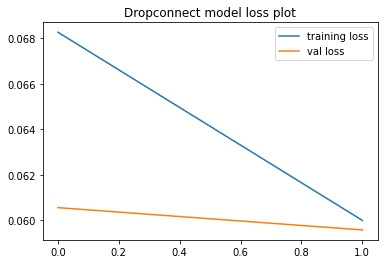

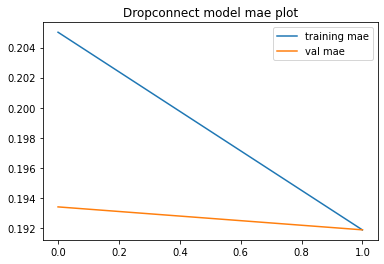

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [19]:
if dropconnect:
    mean_dropconnect, std_dropconnect = train_dropconnect_model(train_data, train_labels, val_data, val_labels, test_data, epochs=epochs, num_samples=num_samples)

## Dropconnect : Ground Truth vs Prediction visualization (Along with  ±   𝑠𝑖𝑔𝑚𝑎  corridor of uncertainty)

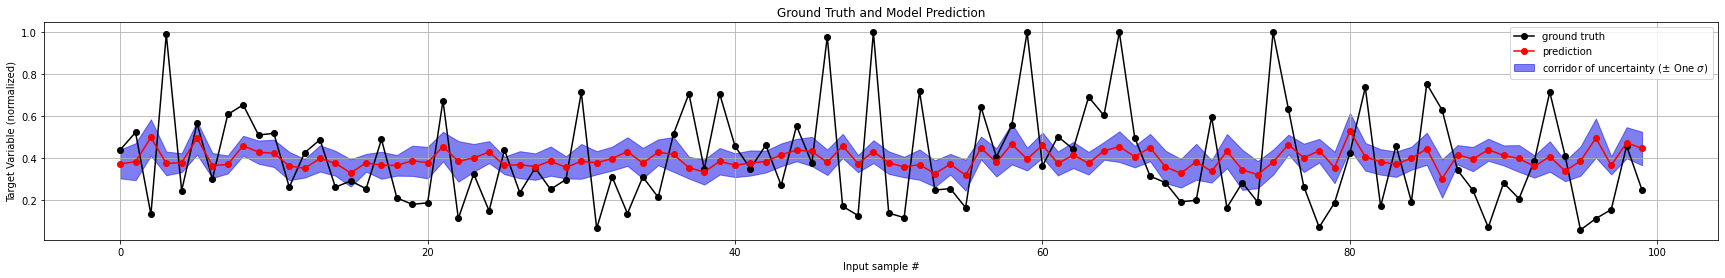

mean_dropconnect  [[0.44294396]
 [0.36736023]
 [0.36457315]
 ...
 [0.365208  ]
 [0.3770969 ]
 [0.42400116]]
number of elements in mean_dropconnect list  3000
std_dropconnect  [[0.0763887 ]
 [0.07709851]
 [0.05908202]
 ...
 [0.04758244]
 [0.08609407]
 [0.07238577]]
number of elements in std_dropconnect list  3000
mean_mean_dropconnect  0.38968474
mean_std_dropconnect  0.06310433
Dropconnect mse (entire dataset)  0.054942701326574424
Dropconnect mse (points visible in plot)  0.05649659463289299
Dropconnect mae (entire dataset)  0.1850031811623762
Dropconnect mae (points visible in plot)  0.1909901573383223


In [20]:
if dropconnect:
    # DROPCONNECT MODEL PREDICTION AND PLOTTING 
    #start_index = np.random.randint(test_data.shape[0]-150)
    #random = range(start_index, start_index+100)

    #print(np.min(test_labels))
    #print(np.min(mean_dropconnect))

    # replace negative values with 0 
    non_negative_mean_dropconnect = np.where(mean_dropconnect<0, 0, test_labels)
    #print(np.min(non_negative_mean_dropconnect))

    test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
    mean_dropconnect_plot = np.asarray([float(mean_dropconnect[i]) for i in random])
    std_dropconnect_plot = np.asarray([float(std_dropconnect[i]) for i in random])

    plot(test_labels_plot, mean_dropconnect_plot, std_dropconnect_plot, path+'results/dropconnect/gt_vs_prediction.pdf')

    print('mean_dropconnect ', mean_dropconnect)
    print('number of elements in mean_dropconnect list ', len(mean_dropconnect))
    print('std_dropconnect ', std_dropconnect)
    print('number of elements in std_dropconnect list ', len(std_dropconnect))
    
    # mean of all mean dropconnect and std dropconnect (3000 samples)
    print('mean_mean_dropconnect ', np.mean(mean_dropconnect))
    print('mean_std_dropconnect ', np.mean(std_dropconnect))

    mse_test_dropconnect = np.mean((test_labels - mean_dropconnect)**2)
    print('Dropconnect mse (entire dataset) ', mse_test_dropconnect)

    mse_test_dropconnect_plot = np.mean((test_labels_plot - mean_dropconnect_plot)**2)
    print('Dropconnect mse (points visible in plot) ', mse_test_dropconnect_plot)

    mae_test_dropconnect = np.mean(np.abs(test_labels - mean_dropconnect))
    print('Dropconnect mae (entire dataset) ', mae_test_dropconnect)

    mse_test_dropconnect_plot = np.mean(np.abs(test_labels_plot - mean_dropconnect_plot)) 
    print('Dropconnect mae (points visible in plot) ', mse_test_dropconnect_plot) 

## Flipout : Model (MLP) 

In [21]:
def train_flipout_model(x_train, y_train, x_val, y_val, x_test, epochs, num_samples):
    num_batches = x_train.shape[0] / 32
    kl_weight = 1.0 / num_batches
    prior_params = {
        'prior_sigma_1': 5.0, 
        'prior_sigma_2': 2.0, 
        'prior_pi': 0.5
    }

    model = Sequential()
    model.add(FlipoutDense(4, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='tanh'))
    model.add(FlipoutDense(4, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='tanh'))
    model.add(FlipoutDense(4, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='tanh'))
    model.add(FlipoutDense(4, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='tanh'))
    model.add(FlipoutDense(4, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='tanh'))
    model.add(FlipoutDense(1, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='softplus'))

    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mae'])

    if os.path.exists('/content/flipout_logs.csv'):
         os.remove('/content/flipout_logs.csv')
         print('Existing file removed!')
          
    
    #csv_logger = CSVLogger('/content/flipout_logs.csv', append=True, separator=';')
    
    history = model.fit(x_train, y_train, 
                        verbose=2, 
                        validation_data=(x_val, y_val), 
                        epochs=epochs,)
                        #callbacks=[csv_logger])
   

    # create path to store plots and trained model 
    if not os.path.exists(path+'results/flipout'):
        os.makedirs(path+'results/flipout')

    # plotting history for individual flipout component 
    plt.plot(range(epochs), history.history['loss'], label='training loss')
    plt.plot(range(epochs), history.history['val_loss'], label='val loss')
    plt.title('Flipout model loss plot')
    plt.legend()
    plt.savefig(path+'results/flipout/loss_plot.pdf')
    plt.show()

    plt.plot(range(epochs), history.history['mae'], label='training mae')
    plt.plot(range(epochs), history.history['val_mae'], label='val mae')
    plt.title('Flipout model mae plot') 
    plt.legend()
    plt.savefig(path+'results/flipout/mae_plot.pdf')
    plt.show()   

    # saving the individual flipout component 
    model.save(path+'results/flipout/model.h5')
    
    st_model = StochasticRegressor(model)
    pred_mean, pred_std = st_model.predict(x_test, num_samples=num_samples)

    return pred_mean, pred_std

## Flipout : Training (MLP)

In [22]:
if flipout:
    mean_flipout, std_flipout = train_flipout_model(train_data, train_labels, val_data, val_labels, test_data, epochs=epochs, num_samples=num_samples)

## Flipout : Ground Truth vs Prediction visualization (Along with ± 𝑠𝑖𝑔𝑚𝑎 corridor of uncertainty)

In [23]:
if flipout:
    # FLIPOUT MODEL PREDICTION AND PLOTTING 
    #start_index = np.random.randint(test_data.shape[0]-150)
    #random = range(start_index, start_index+100)

    #print(np.min(test_labels))
    #print(np.min(mean_flipout))

    # replace negative values with 0 
    non_negative_mean_flipout = np.where(mean_flipout<0, 0, test_labels)
    #print(np.min(non_negative_mean_flipout))

    test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
    mean_flipout_plot = np.asarray([float(mean_flipout[i]) for i in random])
    std_flipout_plot = np.asarray([float(std_flipout[i]) for i in random])

    plot(test_labels_plot, mean_flipout_plot, std_flipout_plot, path+'results/flipout/gt_vs_prediction.pdf')

    print('mean_flipout ', mean_flipout)
    print('number of elements in mean_flipout list ', len(mean_flipout))
    print('std_flipout ', std_flipout)
    print('number of elements in std_flipout list ', len(std_flipout))

    print('mean_mean_flipout ', np.mean(mean_flipout))
    print('mean_std_flipout ', np.mean(std_flipout))

    mse_test_flipout = np.mean((test_labels - mean_flipout)**2)
    print('Flipout mse (entire_dataset)', mse_test_flipout)

    mse_test_flipout_plot = np.mean((test_labels_plot - mean_flipout_plot)**2)
    print('Flipout mse (points visible in plot) ', mse_test_flipout_plot)

    mae_test_flipout = np.mean(np.abs(test_labels - mean_flipout)**2)
    print('Flipout mae (entire dataset)', mae_test_flipout)

    mae_test_flipout_plot = np.mean(np.abs(test_labels_plot - mean_flipout_plot))
    print('Flipout mae(points visible in plot) ', mae_test_flipout_plot)